## This notebook starts from existing azimuth and altitude maps of mouse visual cortex and calculates the visual sign map and segments the sign map into several patches (putative visual areas). 

<br><br>

Currently the [retinotopic_mapping package](https://github.com/zhuangjun1981/retinotopic_mapping) does not include the analysis code which generates altitude and azimuth maps from raw acquired image series and visual stimulation log. This is because 
the various hardware and software people use to display visual stimuli and to acquire images. There is no universal way to preprocess data.

<br><br>

The procedures used in [Zhuang et al., 2017](https://elifesciences.org/articles/18372) to generate altitude and azimuth maps are as follows:

1.	For stimulus sweep in each direction (bottom-up, top-down, nasal-temporal and temporal-nasal), the raw acquired movies were averaged across all presentations. It generated four averaged movies for each sweep direction. The duration of each movie equals the duration of one cycle of corresponding sweep (one sweep across the screen plus inter-sweep gray period). 
2.	For each averaged movie, the mean activity over the pre-sweep gray period was subtracted to generate delta F movies. Delta F movies should look like video 1 in Zhuang et al., 2017, Elife, 6:e18372. There will be four delta F movies, each corresponding to one sweep direction.
3.	Perform fft of each delta F movie along the time dimension and extract the phase of the first harmonic frequency component. Because these are averaged movies, the first harmonic frequency should be the frequency of the visual stimulus sweep. There will be four different phase maps, each corresponding to one sweep direction. Power maps at this particular frequency can be also extracted at this step.
4.	The phase represents the timing within the cycle, by analyzing the visual stimulus log (this part depends on how visual stimulus was displayed which may vary significantly from lab to lab), the phase can be converted to the location of the sweeping checkerboard on screen. After the conversion, four location maps will be generated, each corresponding to a sweep direction.
5.	The location maps of bottom-up and top-down directions were averaged to generate the altitude map, and location maps of nasal-temporal and temporal-nasal directions were averaged to generate the azimuth map.  

<br><br>
In python the code of phase and power extracting looks like these (assuming the first dimension of the movie is time):  
<br><br>
```
import numpy as np

spectrumMovie = np.fft.fft(movie, axis=0)

#generate power movie
powerMovie = (np.abs(spectrumMovie) * 2.) / np.size(movie, 0)
powerMap = np.abs(powerMovie[1,:,:])

#generate phase movie
phaseMovie = np.angle(spectrumMovie)
phaseMap = -1 * phaseMovie[1,:,:]
phaseMap = phaseMap % (2 * np.pi)
```

In [1]:
import os
import glob
import cv2
import numpy as np

import retinotopic_mapping
import retinotopic_mapping.tools.FileTools as ft
import retinotopic_mapping.RetinotopicMapping as rm
import skimage.external.tifffile as tf
import matplotlib.pyplot as plt

%matplotlib inline

In [1545]:
import cv2
from scipy import misc,interpolate,stats,signal
from matplotlib.colors import LinearSegmentedColormap


def smooth_array(inputArray, fwhm, phaseArray=False):
    szList=np.array([None,None,None,11,None,21,None,27,None,31,None,37,None,43,None,49,None,53,None,59,None,55,None,69,None,79,None,89,None,99])
    sigmaList=np.array([None,None,None,.9,None,1.7,None,2.6,None,3.4,None,4.3,None,5.1,None,6.4,None,6.8,None,7.6,None,8.5,None,9.4,None,10.3,None,11.2,None,12])
    sigma=sigmaList[fwhm]
    sz=szList[fwhm]
    #print(sigma, sz)
    if phaseArray:
        outputArray = smooth_phase_array(inputArray,sigma,sz)
    else:
        outputArray=cv2.GaussianBlur(inputArray, (sz,sz), sigma, sigma)
        
    return outputArray
        
def smooth_phase_array(theta,sigma,sz):
    #build 2D Gaussian Kernel
    kernelX = cv2.getGaussianKernel(sz, sigma); 
    kernelY = cv2.getGaussianKernel(sz, sigma); 
    kernelXY = kernelX * kernelY.transpose(); 
    kernelXY_norm=np.true_divide(kernelXY,np.max(kernelXY.flatten()))
    
    #get x and y components of unit-length vector
    componentX=np.cos(theta)
    componentY=np.sin(theta)
    
    #convolce
    componentX_smooth=signal.convolve2d(componentX,kernelXY_norm,mode='same',boundary='symm')
    componentY_smooth=signal.convolve2d(componentY,kernelXY_norm,mode='same',boundary='symm')

    theta_smooth=np.arctan2(componentY_smooth,componentX_smooth)
    return theta_smooth


def shift_map(phase_az):
    phaseC_az=np.copy(phase_az)
    minv = phase_az[~np.isnan(phase_az)].min()
    maxv = phase_az[~np.isnan(phase_az)].max()
    #print(minv, maxv)
    if (minv < 0): # and maxv > 0):
        phaseC_az[phase_az<0]=-phase_az[phase_az<0]
        #print("flipped neg", phaseC_az.min(), phaseC_az.max())
        phaseC_az[phase_az>0]=(2*np.pi)-phase_az[phase_az>0]
        #print("flipped pos", phaseC_az.min(), phaseC_az.max())

    else:
        print("Already non-negative (min/max: %.2f, %.2f)" % (phaseC_az.min(), phaseC_az.max()))
    return phaseC_az


In [1525]:
def label_figure(fig, data_id):
    fig.text(0, .97, data_id)


In [630]:

def convert_range(oldval, newmin=None, newmax=None, oldmax=None, oldmin=None):
    oldrange = (oldmax - oldmin)
    newrange = (newmax - newmin)
    newval = (((oldval - oldmin) * newrange) / oldrange) + newmin
    return newval

In [3]:
# move to package example folder 

package_folder = retinotopic_mapping.__path__
example_folder = os.path.join(package_folder[0], 'examples', 'signmap_analysis')
os.chdir(example_folder)

# Reading example vasculature image

In [4]:
# Base dirs
surface_basedir = '/n/coxfs01/widefield-data/analyzed_data/Retinotopy/phase_encoding/Images_Cartesian_Constant'
analysis_basedir = '/n/coxfs01/widefield-data/analyzed_data/Retinotopy/phase_encoding/Images_Cartesian_Constant'
analysis_subdirs = 'Analyses/timecourse/not_motion_corrected/excludeEdges_averageFrames_11_minusRollingMean'


In [1872]:
# animalid = 'JC085'
# session = '20190620'
animalid = 'JC120'
#session = '20190503'

# find sessions
found_sessions = np.unique([os.path.split(sesh)[-1].split('_')[0] \
                  for sesh in glob.glob(os.path.join(surface_basedir, animalid, '2019*'))])
print('[%s]: Found %i sessions' % (animalid, len(found_sessions)))
for si, sesh in enumerate(found_sessions):
    print(si, sesh)
    

sesh = found_sessions[-1]
surface_path = glob.glob(os.path.join(surface_basedir, animalid, '%s*' % sesh, 'Surface', '*.png'))[0]
session = os.path.split(surface_path.split('/Surface')[0])[-1].split('_')[0]
data_id = '%s_%s' % (animalid, session)
print("DATA ID: %s" % data_id)

[JC120]: Found 1 sessions
(0, '20191105')
DATA ID: JC120_20191105


# Get vasculature image

In [1873]:
surface_path = glob.glob(os.path.join(surface_basedir, animalid, session, 'Surface', '*.png'))[0]
surface = cv2.imread(surface_path, -1)
surface.dtype

dtype('uint16')

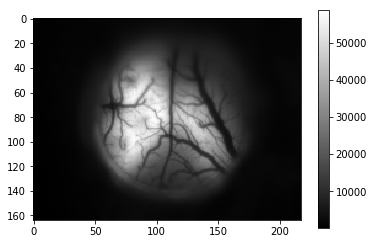

In [1874]:
#vasculature_map = tf.imread('example_vasculature_map.tif')
vasculature_map = cv2.imread(surface_path, -1)
_ = plt.imshow(vasculature_map, cmap='gray', interpolation='nearest')
_ = plt.colorbar()
plt.show()

# Reading example retinotopic maps
cond1 = left
cond2 = right
cond3 = top
cond4 = bottom

In [1875]:
mappaths = glob.glob(os.path.join(analysis_basedir, animalid, '%s*' % session, analysis_subdirs, 'phase_decoding', 'Files', '*.npz'))
for i, p in enumerate(mappaths):
    print(i, p)

cond_key = {'left': 'cond1',
              'right': 'cond2',
              'top': 'cond3',
              'bottom': 'cond4'}

    
if len(mappaths) == 4:
    az_conds = ['left', 'right']
    el_conds = ['top', 'bottom']
else:
    az_conds = ['right']
    el_conds = ['top']

for cond in [az_conds, el_conds]:
    if len(cond) > 1:
        c1 = [m for m in mappaths if cond_key[cond[0]] in m][0]
        c2 = [m for m in mappaths if cond_key[cond[1]] in m][0]
        mapdata1 = np.load(c1)
        mapdata2 = np.load(c2)
        
    

(0, '/n/coxfs01/widefield-data/analyzed_data/Retinotopy/phase_encoding/Images_Cartesian_Constant/JC120/20191105/Analyses/timecourse/not_motion_corrected/excludeEdges_averageFrames_11_minusRollingMean/phase_decoding/Files/20191105_cond2_maps.npz')
(1, '/n/coxfs01/widefield-data/analyzed_data/Retinotopy/phase_encoding/Images_Cartesian_Constant/JC120/20191105/Analyses/timecourse/not_motion_corrected/excludeEdges_averageFrames_11_minusRollingMean/phase_decoding/Files/20191105_cond3_maps.npz')


In [1876]:
shift = True
cmap = 'nipy_spectral'

# mapdata_az = np.load(mappaths[0])
# mapdata_el = np.load(mappaths[1])

mapdata_az = np.load(mappaths[1]) if len(mappaths)==4 else np.load(mappaths[0]) 
mapdata_el = np.load(mappaths[2]) if len(mappaths)==4 else np.load(mappaths[1]) 

if shift:
    altitude_map = shift_map(mapdata_el['phaseMap'].copy())
    azimuth_map = shift_map(mapdata_az['phaseMap'].copy())
else:
    altitude_map = mapdata_el['phaseMap']
    azimuth_map = mapdata_az['phaseMap']


In [1877]:
# altitude_map = tf.imread('example_altitude_map.tif')
# azimuth_map = tf.imread('example_azimuth_map.tif')
# altitude_power_map = tf.imread('example_altitude_power_map.tif')
# azimuth_power_map = tf.imread('example_azimuth_power_map.tif')

# cmap = 'nipy_spectral'


# if shift:
#     vmin_az, vmax_az = 0, 2*np.pi
#     vmin_el, vmax_el = 0, 2*np.pi
# else:
#     vmin_az, vmax_az = -np.pi, np.pi # (0, 120)
#     vmin_el, vmax_el = -np.pi, np.pi # (-40, 60)

# f = plt.figure(figsize=(15, 12))
# ax1 = f.add_subplot(221)

# fig1 = ax1.imshow(altitude_map, vmin=vmin_el, vmax=vmax_el, cmap=cmap, interpolation='nearest')
# ax1.set_axis_off()
# ax1.set_title('altitude map')
# _ = f.colorbar(fig1)

# ax2 = f.add_subplot(222)
# fig2 = ax2.imshow(azimuth_map, vmin=vmin_az, vmax=vmax_az, cmap=cmap, interpolation='nearest')
# ax2.set_axis_off()
# ax2.set_title('azimuth map')
# _ = f.colorbar(fig2)

# ax3 = f.add_subplot(223)
# fig3 = ax3.imshow(altitude_power_map, vmin=0, vmax=1, cmap='hot', interpolation='nearest')
# ax3.set_axis_off()
# ax3.set_title('altitude power map')
# _ = f.colorbar(fig3)

# ax4 = f.add_subplot(224)
# fig4 = ax4.imshow(azimuth_power_map, vmin=0, vmax=1, cmap='hot', interpolation='nearest')
# ax4.set_axis_off()
# ax4.set_title('azimuth power map')
# _ = f.colorbar(fig4)

## filter + smooth

In [1878]:
smooth_fwhm = 7
mag_thr=0.025


phase_az_raw = mapdata_az['phaseMap'].copy()
phase_el_raw = mapdata_el['phaseMap'].copy()
print(phase_el_raw.min(), phase_el_raw.max())

mag_az_raw = mapdata_az['magRatioMap'].copy()
mag_el_raw = mapdata_el['magRatioMap'].copy()

phase_az_smooth = shift_map(smooth_array(phase_az_raw, smooth_fwhm, phaseArray=True))
phase_el_smooth = shift_map(smooth_array(phase_el_raw, smooth_fwhm, phaseArray=True))
print(phase_el_smooth.min(), phase_el_smooth.max())

# phase_az_smooth = smooth_array(phase_az_raw, smooth_fwhm, phaseArray=True)
# phase_el_smooth = smooth_array(phase_el_raw, smooth_fwhm, phaseArray=True)

mag_az_smooth = smooth_array(mag_az_raw, smooth_fwhm, phaseArray=False)
mag_el_smooth = smooth_array(mag_el_raw, smooth_fwhm, phaseArray=False)

# THR by mag
phase_az_smooth[mag_az_smooth<mag_thr] = 0
phase_el_smooth[mag_az_smooth<mag_thr] = 0 
phase_el_smooth[mag_el_smooth<mag_thr] = 0 
phase_az_smooth[mag_el_smooth<mag_thr] = 0

# normalize power
altitude_power_map_normed = mag_el_smooth/mag_el_smooth.max()
azimuth_power_map_normed = mag_az_smooth/mag_az_smooth.max()


(-3.141058014917194, 3.141444464063039)
(0.7200328505169691, 4.440443778439192)


In [1879]:
print("max pwr: %.4f" % mag_az_smooth.max())
print("phase min/max: %.2f / %.2f" % (phase_az_smooth.min(), phase_az_smooth.max()))
print("phase min/max: %.2f / %.2f" % (phase_el_smooth.min(), phase_el_smooth.max()))

max pwr: 0.1941
phase min/max: 0.00 / 6.19
phase min/max: 0.00 / 4.07


In [1971]:
## Convert to degrees
in_degrees = True

lmin_azi, lmax_azi = (-59.78, 59.78)
lmin_alt, lmax_alt = (-33.66, 33.66)

if shift:
    vmin_az, vmax_az = 0, 2*np.pi
    vmin_el, vmax_el = 0, 2*np.pi
else:
    vmin_az, vmax_az = -np.pi, np.pi # (0, 120)
    vmin_el, vmax_el = -np.pi, np.pi # (-40, 60)

print(vmin_el, vmax_el)

phase_az_smooth = convert_range(phase_az_smooth, newmin=lmin_azi, newmax=lmax_azi, oldmin=vmin_az, oldmax=vmax_az)
phase_el_smooth = convert_range(phase_el_smooth, newmin=lmin_alt, newmax=lmax_alt, oldmin=vmin_el, oldmax=vmax_el)

print("phase min/max: %.2f / %.2f" % (phase_az_smooth.min(), phase_az_smooth.max()))

(0, 6.283185307179586)
phase min/max: -59.77 / 59.74


# Set output dir

In [1881]:
aggregate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'
base_dir = os.path.join(aggregate_dir, 'widefield-maps', 'signmaps')
dst_dir = os.path.join(base_dir, 'retinotopic-mapper', data_id)

print(dst_dir)
if not os.path.exists(dst_dir):
    os.makedirs(dst_dir)


/n/coxfs01/julianarhee/aggregate-visual-areas/widefield-maps/signmaps/retinotopic-mapper/JC120_20191105


# Defining image analysis parameters  

#### This is probably the most important part of the whole analysis! The 14 parameters below define the final segmentation results.  
<br>
* phaseMapFilterSigma: The sigma value (in pixels) of Gaussian filter for altitude and azimuth maps. FLOAT, default = 1.0, recommended range: [0.0, 2.0]. Large "phaseMapFilterSigma" gives you more patches. Small "phaseMapFilterSigma" gives you less patches.
<br><br>
* signMapFilterSigma: The sigma value (in pixels) of Gaussian filter for visual sign maps. FLOAT, default = 9.0, recommended range: [0.6, 10.0]. Large "signMapFilterSigma" gives you less patches. Small "signMapFilterSigma" gives you more patches.
<br><br>
* signMapThr: Threshold to binarize visual signmap. FLOAT, default = 0.35, recommended range: [0.2, 0.5], allowed range: [0, 1). Large signMapThr gives you fewer patches. Smaller signMapThr gives you more patches.
<br><br>
* closeIter: Binary close iteration for each raw patches. INT, default = 3. You do not want to change this parameter very often.
<br><br>
* openIter: Binary open iteration for each raw patches. INT, default = 3. You do not want to change this parameter very often
<br><br>
* dilationIter: Binary dilation iteration for each raw patches. INT, default = 15. You do not want to change this parameter very often. 
<br><br>
* borderWidth: Pixel number between adjcent patches. INT, default = 1. You do not want to change this parameter very often.
<br><br>
* smallPatchThr: The patches with pixel number below smallPatchThr will be discarded. INT, default = 100. You do not want to change this parameter very often.
<br><br>
* eccMapFilterSigma: The sigma value of Gaussian filter for eccentricity maps. FLOAT, default = 10.0. You do not want to change this parameter very often.
<br><br>
* visualSpacePixelSize: The pixel size for patch to visual space mapping. FLOAT, default = 0.5. You do not want to change this parameter very often. 
<br><br>
* visualSpaceCloseIter: The binary iteration for visual space coverage for each patch. INT, default = 15. You do not want to change this parameter very often.
<br><br>
* splitLocalMinCutStep: The step width for detecting number of local minimums during spliting. The local minimums detected will be used as marker in the following open cv watershed segmentation. FLOAT, default = 5.0, recommend range: [0.5, 15.0]. Small "splitLocalMinCutStep" will make it more likely to split but into less sub patches. Large "splitLocalMinCutStep" will make it less likely to split but into more sub patches. 
<br><br>
* splitOverlapThr: Patches with overlap ration larger than this value will go through the split procedure. FLOAT, default = 1.1, recommend range: [1.0, 1.2], should be larger than 1.0. Small "splitOverlapThr" will split more patches. Large "splitOverlapThr" will split less patches. 
<br><br>
* mergeOverlapThr: Considering a patch pair (A and B) with same sign, A has visual coverage a deg<sup>2</sup> and B has visual coverage b deg<sup>2</sup> and the overlaping visual coverage between this pair is c deg<sup>2</sup>. Then if (c/a < "mergeOverlapThr") and (c/b < "mergeOverlapThr"), these two patches will be merged. FLOAT, default = 0.1, recommend range: [0.0, 0.2], should be smaller than 1.0. Small "mergeOverlapThr" will merge less patches. Large "mergeOverlapThr" will merge more patches.

In [1882]:
reload(rm)
import json

# Creating the RetinotopicMappingTrail object

In [1939]:
params = {
          'phaseMapFilterSigma': None, # 0,
          'signMapFilterSigma': 6.,
          'signMapThr': 0.35, #0.35, #0.5,
          'eccMapFilterSigma': 10., #9., #10.0,
          'splitLocalMinCutStep': 5.,
          'closeIter': 3,
          'openIter': 3,
          'dilationIter': 15,
          'borderWidth': 1,
          'smallPatchThr': 100,
          'visualSpacePixelSize': 0.5, #5,
          'visualSpaceCloseIter': 15,
          'splitOverlapThr': 1.01,
          'mergeOverlapThr': 0.01,
          'lmin_alt': lmin_alt,
          'lmax_alt': lmax_alt, 
          'lmin_azi': lmin_azi,
          'lmax_azi': lmax_azi, 
          
          # preprocessing 
          'mag_thr': mag_thr,
          'smooth_fwhm': smooth_fwhm
          }


params_fpath = os.path.join(dst_dir, '%s_params.json' % data_id)
with open(params_fpath, 'w') as f:
    json.dump(params, f, indent=4, sort_keys=True)

In [1972]:
# altitude_phase_map = shift_map(phase_el_raw.copy()) #phase_el_smooth.copy()
# azimuth_phase_map = shift_map(phase_az_raw.copy()) #phase_az_smooth.copy()
# azimuth_phase_map = convert_range(azimuth_phase_map, newmin=lmin_azi, newmax=lmax_azi, oldmin=vmin_az, oldmax=vmax_az)
# altitude_phase_map = convert_range(altitude_phase_map, newmin=lmin_alt, newmax=lmax_alt, oldmin=vmin_el, oldmax=vmax_el)

altitude_phase_map = phase_el_smooth.copy()
azimuth_phase_map = phase_az_smooth.copy()

altitude_power_map = mag_el_smooth.copy()
azimuth_power_map = mag_az_smooth.copy()

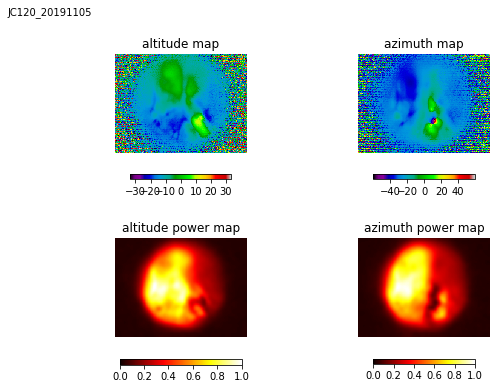

In [1973]:
cmap = 'nipy_spectral'

f = plt.figure(figsize=(8, 6))
ax1 = f.add_subplot(221)
if in_degrees:
    vmin_az, vmax_az = (lmin_azi, lmax_azi)
    vmin_el, vmax_el = (lmin_alt, lmax_alt)
else:
    if shift:
        vmin_az, vmax_az = 0, 2*np.pi
        vmin_el, vmax_el = 0, 2*np.pi
    else:
        vmin_az, vmax_az = -np.pi, np.pi # (0, 120)
        vmin_el, vmax_el = -np.pi, np.pi # (-40, 60)

fig1 = ax1.imshow(altitude_phase_map, vmin=vmin_el, vmax=vmax_el, cmap=cmap, interpolation='nearest')
ax1.set_axis_off()
ax1.set_title('altitude map')
_ = f.colorbar(fig1, orientation='horizontal', shrink=0.5)

ax2 = f.add_subplot(222)
fig2 = ax2.imshow(azimuth_phase_map, vmin=vmin_az, vmax=vmax_az, cmap=cmap, interpolation='nearest')
ax2.set_axis_off()
ax2.set_title('azimuth map')
_ = f.colorbar(fig2, orientation='horizontal', shrink=0.5)

ax3 = f.add_subplot(223)
fig3 = ax3.imshow(altitude_power_map_normed, vmin=0, vmax=1, cmap='hot', interpolation='nearest')
ax3.set_axis_off()
ax3.set_title('altitude power map')
_ = f.colorbar(fig3, orientation='horizontal', shrink=0.6)

ax4 = f.add_subplot(224)
fig4 = ax4.imshow(azimuth_power_map_normed, vmin=0, vmax=1, cmap='hot', interpolation='nearest')
ax4.set_axis_off()
ax4.set_title('azimuth power map')
_ = f.colorbar(fig4, orientation='horizontal', shrink=0.5)

plt.subplots_adjust(hspace=0.3, wspace=0.2)

label_figure(f, data_id)
plt.savefig(os.path.join(dst_dir, '%s_input_maps.png' % data_id))

# Create trial object

In [1974]:

# Create trial object
trial = rm.RetinotopicMappingTrial(altPosMap=altitude_phase_map,
                                   aziPosMap=azimuth_phase_map,
                                   altPowerMap=altitude_power_map,
                                   aziPowerMap=azimuth_power_map,
                                   vasculatureMap=vasculature_map,
                                   mouseID=animalid,
                                   dateRecorded=session,
                                   comments='This is an example.',
                                   params=params)

In [1975]:
print trial

A retinotopic mapping trial: 20191105_MJC120


# Generating visual sign map

In [1976]:
trial.getName()

'20191105_MJC120'

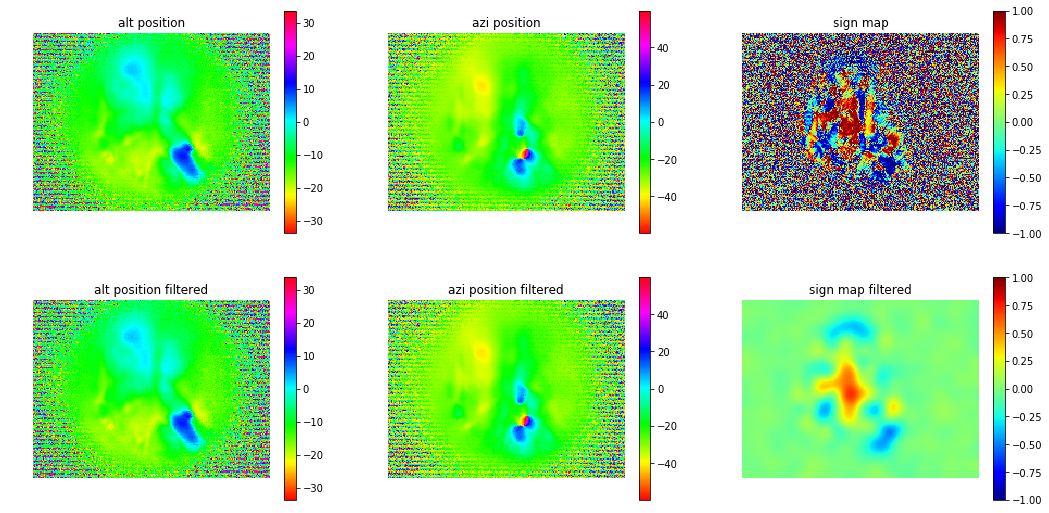

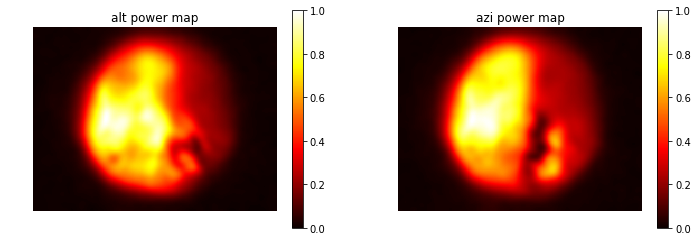

In [1977]:
_ = trial._getSignMap(isPlot=True, isFixedRange=True)
# f1 = plot_getSignMap(trial, isFixedRange=True)

# label_figure(f1, data_id)
#plt.savefig(os.path.join(dst_dir, '%s_get_sign_map.png' % data_id))

In [1946]:
trial.params['lmin_alt'], trial.params['lmax_alt']

(-33.66, 33.66)

patch09AU=0.0 AS=16.78561776076832 ratio=inf
Only one local minumum was found!!!
patch08AU=82.5 AS=1074.3106837991131 ratio=13.021947682413492
Only one local minumum was found!!!
patch05AU=0.0 AS=45.91761462394764 ratio=inf
Only one local minumum was found!!!
patch04AU=0.0 AS=69.20526306052237 ratio=inf
Only one local minumum was found!!!
patch07AU=0.0 AS=17.12591571540571 ratio=inf
Only one local minumum was found!!!
patch06AU=0.0 AS=109.9043805272443 ratio=inf
Only one local minumum was found!!!
patch01AU=37.5 AS=588.169313313199 ratio=15.684515021685307
2 local minuma were found!!!
patch10AU=0.0 AS=90.71578175419852 ratio=inf
Only one local minumum was found!!!
patch03AU=0.0 AS=308.2778014451103 ratio=inf
Only one local minumum was found!!!
patch02AU=490.25 AS=4560.409666480843 ratio=9.302212476248533
5 local minuma were found!!!
merge iteration: 1
merging: patch02.1 & patch08, overlap ratio: 0.0
merge iteration: 2


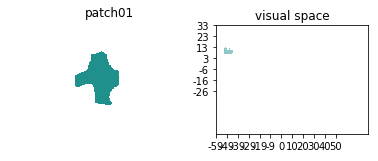

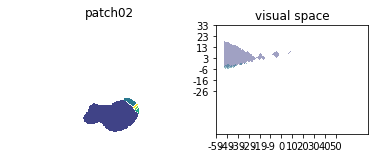

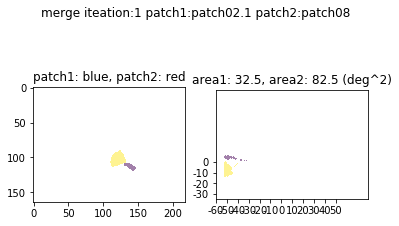

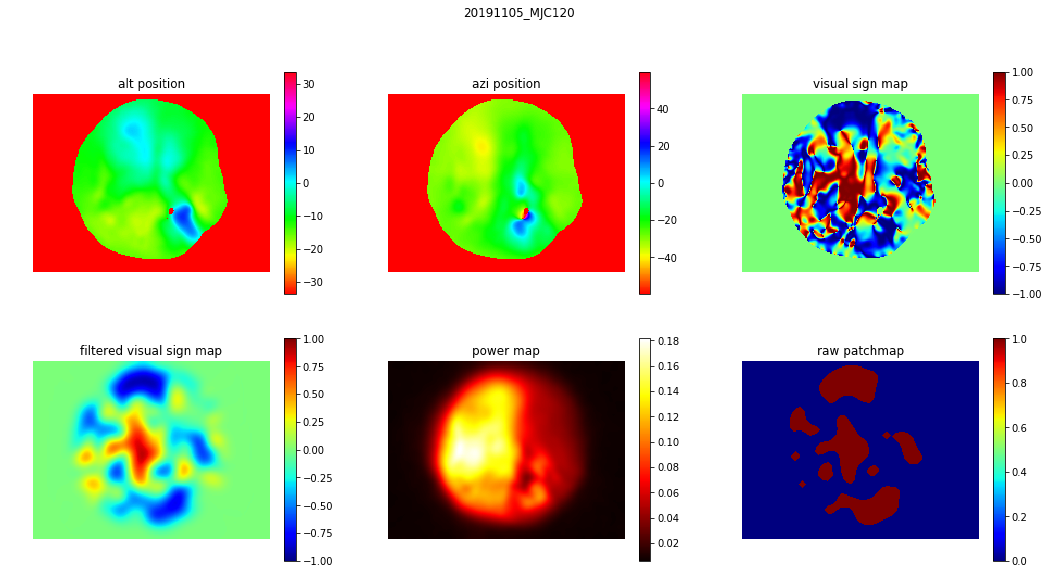

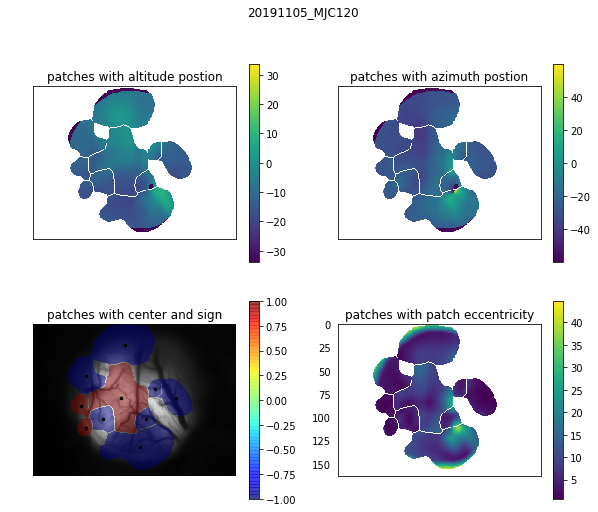

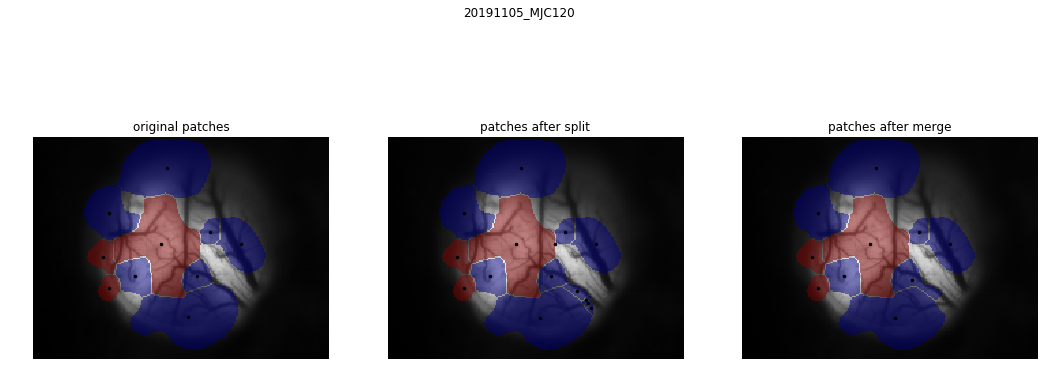

In [1947]:
trial.plotTrial(isSave=True, saveFolder=dst_dir)

# Binarizing filtered visual signmap

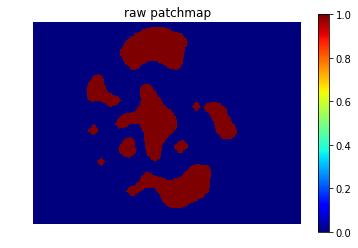

In [1948]:
_ = trial._getRawPatchMap(isPlot=True)
plt.show()

# Generating raw patches

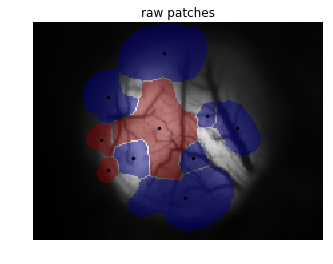

In [1949]:
_ = trial._getRawPatches(isPlot=True)
plt.show()

# Generating determinant map

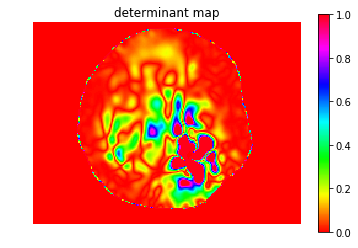

In [1950]:
_ = trial._getDeterminantMap(isPlot=True)
plt.show()

# Generating eccentricity map for each patch

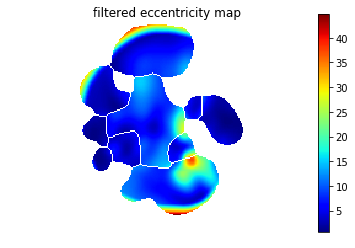

In [1951]:
_ = trial._getEccentricityMap(isPlot=True)
plt.show()

# Splitting overlapping patches

patch09AU=0.0 AS=16.78561776076832 ratio=inf
Only one local minumum was found!!!
patch08AU=82.5 AS=1074.3106837991131 ratio=13.021947682413492
Only one local minumum was found!!!
patch05AU=0.0 AS=45.91761462394764 ratio=inf
Only one local minumum was found!!!
patch04AU=0.0 AS=69.20526306052237 ratio=inf
Only one local minumum was found!!!
patch07AU=0.0 AS=17.12591571540571 ratio=inf
Only one local minumum was found!!!
patch06AU=0.0 AS=109.9043805272443 ratio=inf
Only one local minumum was found!!!
patch01AU=37.5 AS=588.169313313199 ratio=15.684515021685307
2 local minuma were found!!!
patch10AU=0.0 AS=90.71578175419852 ratio=inf
Only one local minumum was found!!!
patch03AU=0.0 AS=308.2778014451103 ratio=inf
Only one local minumum was found!!!
patch02AU=490.25 AS=4560.409666480843 ratio=9.302212476248533
5 local minuma were found!!!


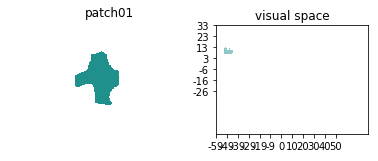

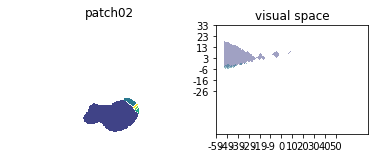

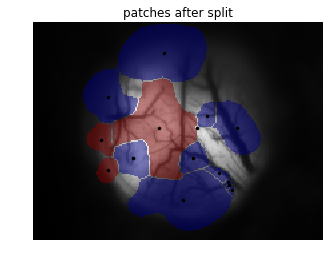

In [1952]:
_ = trial._splitPatches(isPlot=True)
plt.show()

# Merging non-overlapping patches

merge iteration: 1
merging: patch02.1 & patch08, overlap ratio: 0.0
merge iteration: 2


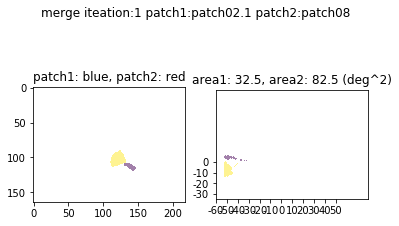

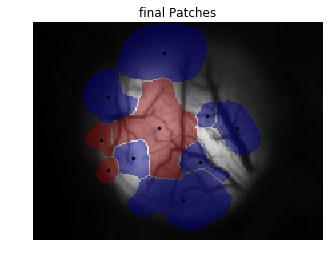

In [1953]:
_ = trial._mergePatches(isPlot=True)
plt.show()

## Note:  
### The methods used from cell 8 to cell 14 are protected by leading underscore! Here they were used separately to show every single image analysis step. In real life, the steps from cell 8 to cell 14 can be consolidated into one single method:  

`trial.processTrial(isPlot=True)`

# Plotting results

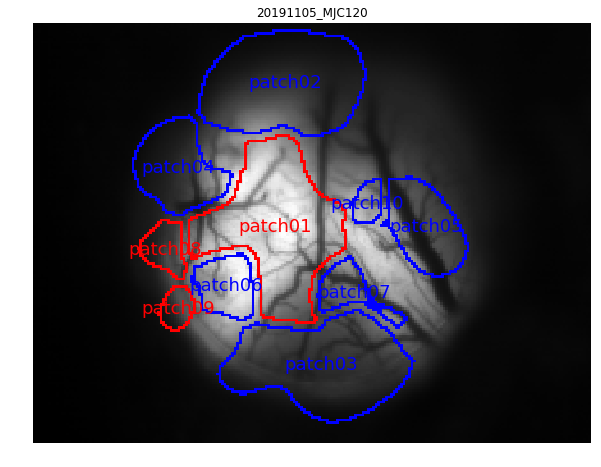

In [1954]:
f = trial.plotFinalPatchBorders(borderWidth=2, fontSize=18)

#plt.show()

plt.savefig(os.path.join(dst_dir, '%s_final_patch_borders.png' % trial.getName()))
plt.show()


# Annotating segmented patches

In [1959]:
names = [
         ['patch04', 'V1a (split)'],
         ['patch06', 'V1b (split)'],

         ['patch01', 'LM (split)'],
         ['patch07', 'LI'],
         ['patch03', 'LIb? (partial)'],
#          ['patch05', 'AL']
#          ['patch05', 'LI'],
#          ['patch06', 'AM'],
#          ['patch07', 'LI'],
#          ['patch08', 'MMA'],
#          ['patch09', 'AL'],
#          ['patch10', 'RLL'],
#          ['patch11', 'LLA'],
         ]

finalPatchesMarked = dict(trial.finalPatches)

for i, namePair in enumerate(names):
    currPatch = finalPatchesMarked.pop(namePair[0])
    newPatchDict = {namePair[1]:currPatch}
    finalPatchesMarked.update(newPatchDict)
    
trial.finalPatchesMarked = finalPatchesMarked

# Ploting final results

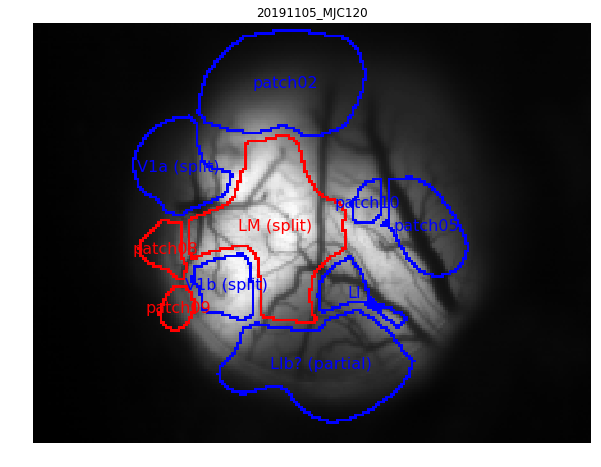

In [1960]:
_ = trial.plotFinalPatchBorders()

plt.savefig(os.path.join(dst_dir, '%s_final_patch_borders_labeled.png' % trial.getName()))

plt.show()

# Generating dictionary for saving

In [1961]:
trialDict = trial.generateTrialDict()
trialDict.keys()

['eccentricityMapf',
 'mouseID',
 'aziPowerMap',
 'altPosMapf',
 'altPowerMap',
 'aziPowerMapf',
 'comments',
 'aziPosMap',
 'altPosMap',
 'finalPatchesMarked',
 'signMapf',
 'params',
 'finalPatches',
 'vasculatureMap',
 'signMap',
 'dateRecorded',
 'altPowerMapf',
 'rawPatchMap',
 'aziPosMapf']

# Saving results

In [1962]:
results_fpath = os.path.join(dst_dir, '%s_results.pkl' % trial.getName())
ft.saveFile(results_fpath, trialDict)